In [1]:

%pip install torch

%pip install matplotlib
%pip install jaxtyping


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import time
from torch.utils.data import Dataset, DataLoader
import random, numpy
from dataclasses import dataclass
from jaxtyping import Float, Int
from torch import Tensor
from typing import Optional, Callable, Union, List, Tuple
import copy

In [ ]:
t.device("cuda" if t.cuda.is_available() else "cpu")

device(type='cpu')

In [3]:
@dataclass
class Parameters:
    d_vocab: int = 2048
    d_model: int = 128
    num_epoch: int = 6
    batch_size: int = 1024
    subset_percentage: float = 2.5
    lr: float = 0.001


params = Parameters()

In [4]:
def set_seed(seed: int = 57) -> None:
    numpy.random.seed(seed)
    random.seed(seed)
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' executed in: {elapsed_time:.6f} seconds")
        return result, elapsed_time

    return wrapper

In [6]:
class TrainingDataMax(Dataset):
    def __init__(self, params):
        set_seed(57)
        self.n = params.d_vocab

    def __getitem__(self, idx):

        x = random.randint(0, self.n - 1)
        y = random.randint(0, self.n - 1)

        return x, y, max(x, y)

    def __len__(self):
        return self.n * self.n


# set seed -> random select in gettitem

In [7]:
def test_dataset(dataset, batch_size=4, num_workers=0):
    """
    Function to test a PyTorch Dataset.

    Parameters:
    - dataset (torch.utils.data.Dataset): The dataset to be tested.
    - batch_size (int): Number of samples per batch to load.
    - num_workers (int): How many subprocesses to use for data loading.

    Returns:
    None. Prints information about the batches.
    """

    print("Loading data...")
    train_data = TrainingDataMax(params=Parameters)
    print("Train data defined")
    dataloader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)
    print("Data loaded")

    print(f"Testing {dataset.__class__.__name__} with {len(dataset)} samples...")

    for i_batch, sample_batched in enumerate(dataloader):
        print(f"Batch {i_batch + 1}")

        # Print shapes or other relevant info about each element in sample_batched
        for x in sample_batched:
            print(x)

In [8]:
train_data = TrainingDataMax(params=Parameters)
test_dataset(train_data)

Loading data...
Train data defined
Data loaded
Testing TrainingDataMax with 4194304 samples...
Batch 1
tensor([ 174,   79, 1315,  ..., 1192, 1658,  271])
tensor([1506,  921, 1955,  ...,  479,  115,  733])
tensor([1506,  921, 1955,  ..., 1192, 1658,  733])
Batch 2
tensor([ 480, 1886, 1393,  ..., 1048, 1003, 1932])
tensor([ 238, 1828, 1600,  ...,  893, 1835,  834])
tensor([ 480, 1886, 1600,  ..., 1048, 1835, 1932])
Batch 3
tensor([1672,  317,  123,  ..., 1941,  227, 1152])
tensor([1976, 1544,  586,  ..., 1598, 1869,  779])
tensor([1976, 1544,  586,  ..., 1941, 1869, 1152])
Batch 4
tensor([ 556,  853, 1558,  ..., 1299, 1514,  675])
tensor([ 359,  764,  339,  ..., 1176, 1938,  893])
tensor([ 556,  853, 1558,  ..., 1299, 1938,  893])
Batch 5
tensor([1363,  648,  910,  ..., 1189,  253,  301])
tensor([  20, 2008, 1986,  ..., 1485,  664,  607])
tensor([1363, 2008, 1986,  ..., 1485,  664,  607])
Batch 6
tensor([1764, 1009,  177,  ..., 1002, 1227, 1478])
tensor([ 600, 1681, 1391,  ...,  566, 203

KeyboardInterrupt: 

In [72]:
class MLP(t.nn.Module):
    def __init__(self, params):
        super().__init__()
        self.embedding = t.nn.Linear(params.d_vocab, params.d_model, bias=False)
        self.linear = t.nn.Linear(params.d_model, params.d_model, bias=False)
        self.activation = t.nn.ReLU()
        self.unembedding = t.nn.Linear(params.d_model, params.d_vocab, bias=False)

    def g(self, x):
        print(x.shape)

        return self.unembedding(self.activation(self.linear(x)))

    def forward(self, a):

        return self.g(self.embedding(a.sum(dim=1)))

In [63]:
def test_model(model, dataset):
    """
    Function to test a PyTorch Model.

    Parameters:
    - model (torch.nn.Module): The trained model to be tested.
    - dataloader (torch.utils.data.DataLoader): Dataloader for loading test data.
    - criterion (torch.nn.Module): Loss function used for evaluating loss.

    Returns:
        None. Prints out average loss and accuracy over all batches.
    """

    device = t.device("cuda" if t.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    total_loss = 0.0
    correct_predictions = 0

    dataloader = DataLoader(
        dataset, batch_size=30, shuffle=True, num_workers=0, drop_last=False
    )

    m = t.nn.LogSoftmax(dim=-1)
    criterion = t.nn.CrossEntropyLoss()
    with t.no_grad():
        for i_batch, sample_batched in enumerate(dataloader):

            inputs, labels = t.stack(sample_batched[:-1], dim=1), sample_batched[-1]

            inputs_one_hot = F.one_hot(inputs, params.d_vocab).float()
            print(inputs_one_hot.shape)

            outputs = model(inputs_one_hot)

            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, preds = t.max(outputs, 1)

            correct_predictions += (preds == labels).sum().item()

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / len(dataloader)

        print(f"Average Loss: {avg_loss:.4f} Accuracy: {accuracy:.2f}%")

In [73]:
model = MLP(params=Parameters)
test_model(model=model, dataset=train_data)

torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30, 128])
torch.Size([30, 2, 2048])
torch.Size([30

KeyboardInterrupt: 

In [91]:
def training_step(
    model,
    optimizer,
    batch: Tuple[
        Int[Tensor, "batch_size"], Int[Tensor, "batch_size"], Int[Tensor, "batch_size"]
    ],
    params: Parameters,
):

    criterion = t.nn.CrossEntropyLoss()

    x, y, labels = batch

    x_one_hot = F.one_hot(x, params.d_vocab).float()

    y_one_hot = F.one_hot(y, params.d_vocab).float()

    inputs = t.stack([x_one_hot, y_one_hot], dim=1)

    logits = model(inputs)
    loss = criterion(logits, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss

In [92]:
def train(model, params):

    loss_history = []

    subset_cardinality = int(
        len(TrainingDataMax(params=Parameters)) * (params.subset_percentage / 100)
    )
    remaining_cardinality = len(TrainingDataMax(params=params)) - subset_cardinality

    print("Loading data...")
    train_data, _ = t.utils.data.random_split(
        TrainingDataMax(params=Parameters), [subset_cardinality, remaining_cardinality]
    )
    print("Train data defined")
    dataloader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)
    print("Data loaded")

    optimizer = t.optim.AdamW(
        model.parameters(),
        lr=params.lr,
    )

    for epoch in range(params.num_epoch):
        for i, batch in enumerate(dataloader):
            print(i * params.batch_size)
            loss = training_step(
                model=model, optimizer=optimizer, batch=batch, params=params
            )

            loss_history.append(loss.detach().item())

    return loss_history

In [93]:
model = MLP(params=Parameters)
loss_history = train(model=model, params=params)

Loading data...
Train data defined
Data loaded
0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936
40960
41984
43008
44032
45056
46080
47104
48128
49152
50176
51200
52224
53248
54272
55296
56320
57344
58368
59392
60416
61440
62464
63488
64512
65536
66560
67584
68608
69632
70656
71680
72704
73728
74752
75776
76800
77824
78848
79872
80896
81920
82944
83968
84992
86016
87040
88064
89088
90112
91136
92160
93184
94208
95232
96256
97280
98304
99328
100352
101376
102400
103424
104448
0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936
40960
41984
43008
44032
45056
46080
47104
48128
49152
50176
51200
52224
53248
54272
55296
56320
57344
58368
59392
60

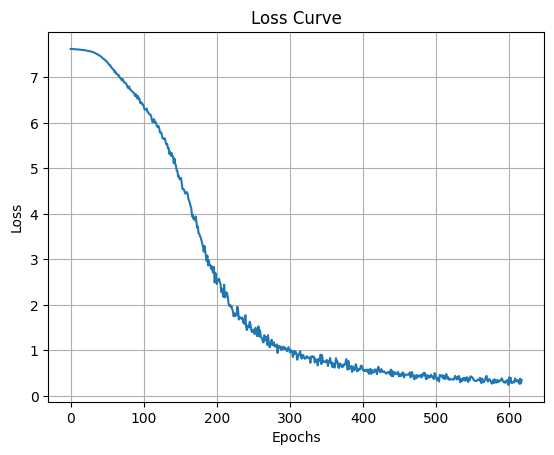

In [95]:
plt.plot(loss_history)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [96]:
train_data = TrainingDataMax(params=Parameters)
# test_dataset(train_data)

In [98]:
def loss_two_points(model, x: int, y: int):

    criterion = t.nn.CrossEntropyLoss()

    with t.no_grad():

        x_tensor = t.tensor([x])
        y_tensor = t.tensor([y])

        labels = t.max(x_tensor, y_tensor)

        inputs = t.stack(
            [
                F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
            ],
            dim=1,
        )

        outputs = model(inputs)

        loss = criterion(outputs, labels)

    return outputs.squeeze(0), loss.detach().item()

In [99]:
logit, loss = loss_two_points(model=model, x=55, y=2000)

print(logit[54:60])
print(loss)

tensor([-30.6762, -31.5801, -29.2922, -32.4318, -31.6018, -27.4103])
0.0006335158832371235


In [100]:
print(loss_history[-5:])

[0.3303828239440918, 0.26676833629608154, 0.3795314133167267, 0.27278199791908264, 0.35188451409339905]


In [21]:
def brute_force_accuracy_proof(model, params):
    count = 0

    with t.no_grad():
        model.eval()

        for x in range(1, params.d_vocab):
            print(x / params.d_vocab)

            x_tensor = t.tensor([x] * (params.d_vocab))
            y_tensor = t.tensor([i for i in range(params.d_vocab)])

            labels = t.max(x_tensor, y_tensor)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            predicted_label = t.argmax(outputs, dim=1)

            correct_predictions = labels == predicted_label
            count += correct_predictions.sum()

    return count / params.d_vocab**2

In [72]:
brute_force_accuracy_proof(model=model, params=params)

0.0
0.00048828125
0.0009765625
0.00146484375
0.001953125
0.00244140625
0.0029296875
0.00341796875
0.00390625
0.00439453125
0.0048828125
0.00537109375
0.005859375
0.00634765625
0.0068359375
0.00732421875
0.0078125
0.00830078125
0.0087890625
0.00927734375
0.009765625
0.01025390625
0.0107421875
0.01123046875
0.01171875
0.01220703125
0.0126953125
0.01318359375
0.013671875
0.01416015625
0.0146484375
0.01513671875
0.015625
0.01611328125
0.0166015625
0.01708984375
0.017578125
0.01806640625
0.0185546875
0.01904296875
0.01953125
0.02001953125
0.0205078125
0.02099609375
0.021484375
0.02197265625
0.0224609375
0.02294921875
0.0234375
0.02392578125
0.0244140625
0.02490234375
0.025390625
0.02587890625
0.0263671875
0.02685546875
0.02734375
0.02783203125
0.0283203125
0.02880859375
0.029296875
0.02978515625
0.0302734375
0.03076171875
0.03125
0.03173828125
0.0322265625
0.03271484375
0.033203125
0.03369140625
0.0341796875
0.03466796875
0.03515625
0.03564453125
0.0361328125
0.03662109375
0.037109375
0.037

tensor(0.9447)

In [49]:
@measure_time
def brute_force_loss_proof(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss()

    with t.no_grad():
        model.eval()

        for x in range(0, params.d_vocab):
            print(x / params.d_vocab)

            x_tensor = t.tensor([x] * (params.d_vocab))
            y_tensor = t.tensor([i for i in range(params.d_vocab)])

            labels = t.max(x_tensor, y_tensor)

            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            loss += criterion(outputs, labels)

    return loss / params.d_vocab

In [53]:
performance_time = []

In [50]:
loss_bf, time_bf = brute_force_loss_proof(model=model, params=params)

0.0
0.00048828125
0.0009765625
0.00146484375
0.001953125
0.00244140625
0.0029296875
0.00341796875
0.00390625
0.00439453125
0.0048828125
0.00537109375
0.005859375
0.00634765625
0.0068359375
0.00732421875
0.0078125
0.00830078125
0.0087890625
0.00927734375
0.009765625
0.01025390625
0.0107421875
0.01123046875
0.01171875
0.01220703125
0.0126953125
0.01318359375
0.013671875
0.01416015625
0.0146484375
0.01513671875
0.015625
0.01611328125
0.0166015625
0.01708984375
0.017578125
0.01806640625
0.0185546875
0.01904296875
0.01953125
0.02001953125
0.0205078125
0.02099609375
0.021484375
0.02197265625
0.0224609375
0.02294921875
0.0234375
0.02392578125
0.0244140625
0.02490234375
0.025390625
0.02587890625
0.0263671875
0.02685546875
0.02734375
0.02783203125
0.0283203125
0.02880859375
0.029296875
0.02978515625
0.0302734375
0.03076171875
0.03125
0.03173828125
0.0322265625
0.03271484375
0.033203125
0.03369140625
0.0341796875
0.03466796875
0.03515625
0.03564453125
0.0361328125
0.03662109375
0.037109375
0.037

In [54]:
performance_time.append((loss_bf, time_bf))

In [77]:
def symmetry_proof_accuracy(model, params):
    count = 0

    with t.no_grad():
        model.eval()

        for x in range(0, params.d_vocab):
            print(x)
            x_tensor = t.tensor([x] * (params.d_vocab - x))
            y_tensor = t.tensor([x + i for i in range(params.d_vocab - x)])

            labels = t.max(x_tensor, y_tensor)
            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            predicted_label = t.argmax(outputs, dim=1)

            correct_predictions = labels == predicted_label
            count += correct_predictions.sum()

    return count / ((params.d_vocab**2 + params.d_vocab) * 0.5)

In [76]:
symmetry_proof_accuracy(model=model, params=params)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

tensor(0.9447)

In [101]:
@measure_time
def symmetry_proof_loss(model, params):
    loss = 0
    criterion = t.nn.CrossEntropyLoss()
    with t.no_grad():
        model.eval()
        for x in range(0, params.d_vocab - 1):
            print(x / (params.d_vocab - 1))
            x_tensor = t.tensor([x] * (params.d_vocab - x - 1))
            y_tensor = t.tensor([x + i + 1 for i in range(params.d_vocab - x - 1)])

            labels = t.max(x_tensor, y_tensor)
            inputs = t.stack(
                [
                    F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                    F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
                ],
                dim=1,
            )

            outputs = model(inputs)

            loss += criterion(outputs, labels) * 2 * len(x_tensor)

            loss += loss_two_points(model=model, x=x, y=x)[1]

        loss += loss_two_points(
            model=model, x=params.d_vocab - 1, y=params.d_vocab - 1
        )[1]

    return loss / (params.d_vocab * params.d_vocab)

In [102]:
loss_sym, time_sym = symmetry_proof_loss(model=model, params=params)

0.0
0.0004885197850512946
0.0009770395701025891
0.0014655593551538837
0.0019540791402051783
0.002442598925256473
0.0029311187103077674
0.003419638495359062
0.0039081582804103565
0.004396678065461651
0.004885197850512946
0.00537371763556424
0.005862237420615535
0.006350757205666829
0.006839276990718124
0.0073277967757694185
0.007816316560820713
0.008304836345872008
0.008793356130923302
0.009281875915974597
0.009770395701025891
0.010258915486077186
0.01074743527112848
0.011235955056179775
0.01172447484123107
0.012212994626282364
0.012701514411333659
0.013190034196384953
0.013678553981436248
0.014167073766487542
0.014655593551538837
0.015144113336590131
0.015632633121641426
0.01612115290669272
0.016609672691744015
0.01709819247679531
0.017586712261846604
0.0180752320468979
0.018563751831949193
0.019052271617000488
0.019540791402051783
0.020029311187103077
0.02051783097215437
0.021006350757205666
0.02149487054225696
0.021983390327308255
0.02247191011235955
0.022960429897410845
0.0234489496

In [103]:
loss_sym

tensor(0.3102)

In [57]:
performance_time.append((loss_sym, time_sym))

In [104]:
diagonal_loss = [
    loss_two_points(model=model, x=i, y=i)[1] for i in range(params.d_vocab)
]

diagonal_output = [
    loss_two_points(model=model, x=i, y=i)[0] for i in range(params.d_vocab)
]

In [115]:
def f(i, j):
    criterion = t.nn.CrossEntropyLoss()
    return criterion(diagonal_output[j].unsqueeze(0), t.tensor([i])).detach().item()

In [116]:
i, j = params.d_vocab, params.d_vocab

# Create meshgrid of indices
i_indices = t.arange(i).view(-1, 1).expand(-1, i)
j_indices = t.arange(j).view(1, -1).expand(j, -1)

# Apply the function to each pair of indices
result_tensor = t.stack(
    [f(i.item(), j.item()) for i, j in zip(i_indices.flatten(), j_indices.flatten())]
).reshape(i, j)

print(result_tensor)

KeyboardInterrupt: 

In [112]:
criterion = t.nn.CrossEntropyLoss()
loss_convex = 0


for i in range(params.d_vocab):
    print(i)
    for j in range(i):
        factor = 1 if i == j else 2
        loss_convex += factor * (
            criterion(diagonal_output[j].unsqueeze(0), t.tensor([i])).detach().item()
            + criterion(diagonal_output[i].unsqueeze(0), t.tensor([i])).detach().item()
        )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

21.227125736259058

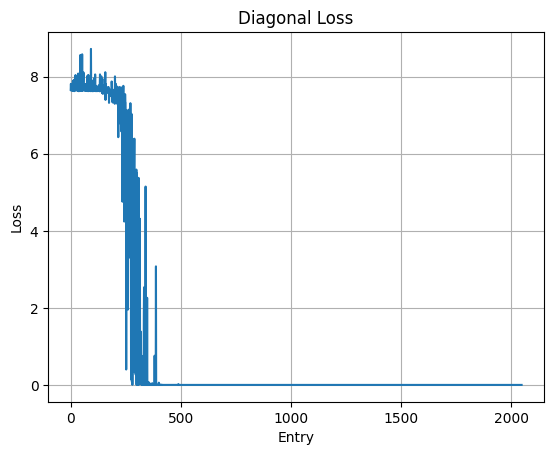

In [105]:
plt.plot(diagonal_loss)
plt.title("Diagonal Loss")
plt.xlabel("Entry")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [60]:
loss_estimate = 0

for i in range(params.d_vocab):
    for j in range(params.d_vocab):
        loss_estimate += max(diagonal_loss[i], diagonal_loss[j])

loss_convex = loss_estimate / params.d_vocab**2


print(loss_estimate)

8278952.19258868


In [61]:
performance_time.append((loss_convex, 1.6 + 0.7))

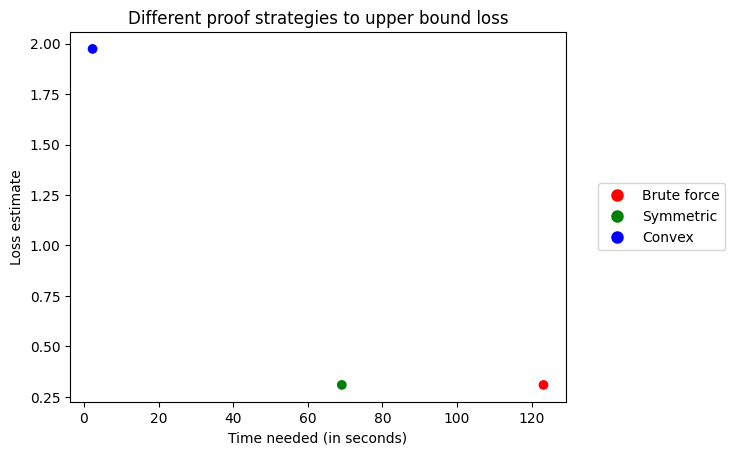

In [67]:
x = [performance_time[i][1] for i in range(3)]
y = [performance_time[i][0] for i in range(3)]
labels = ["Brute force", "Symmetric", "Convex"]
colors = ["red", "green", "blue"]


# Create plot
plt.scatter(x, y, c=colors)


for label, color in zip(labels, colors):
    plt.plot([], [], marker="o", linestyle="", markersize=8, color=color, label=label)

plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.title("Different proof strategies to upper bound loss")
plt.xlabel("Time needed (in seconds)")
plt.ylabel("Loss estimate")
plt.show()

In [43]:
def convexity_proof(model, params):

    for x in range(0, params.d_vocab):
        print(x)
        x_tensor = t.tensor([x] * (params.d_vocab - x))
        y_tensor = t.tensor([x + i for i in range(params.d_vocab - x)])

        labels = t.max(x_tensor, y_tensor)
        inputs = t.stack(
            [
                F.one_hot(x_tensor, num_classes=params.d_vocab).float(),
                F.one_hot(y_tensor, num_classes=params.d_vocab).float(),
            ],
            dim=1,
        )

        outputs = model(inputs)

        predicted_label = t.argmax(outputs, dim=1)

        correct_predictions = labels == predicted_label
        count += correct_predictions.sum()

    return count / ((params.d_vocab**2 + params.d_vocab) * 0.5)

## Comparing losses

In [66]:
params_compare = Parameters(batch_size=2048, subset_percentage=5, num_epoch=4)

In [67]:
model_baseline = MLP(params=params_compare)
model_convex = copy.deepcopy(model_baseline)

In [68]:
loss_baseline = train(model=model_baseline, params=params_compare)

Loading data...
Train data defined
Data loaded
0
2048
4096
6144
8192
10240
12288
14336
16384
18432
20480
22528
24576
26624
28672
30720
32768
34816
36864
38912
40960
43008
45056
47104
49152
51200
53248
55296
57344
59392
61440
63488
65536
67584
69632
71680
73728
75776
77824
79872
81920
83968
86016
88064
90112
92160
94208
96256
98304
100352
102400
104448
106496
108544
110592
112640
114688
116736
118784
120832
122880
124928
126976
129024
131072
133120
135168
137216
139264
141312
143360
145408
147456
149504
151552
153600
155648
157696
159744
161792
163840
165888
167936
169984
172032
174080
176128
178176
180224
182272
184320
186368
188416
190464
192512
194560
196608
198656
200704
202752
204800
206848
208896
0
2048
4096
6144
8192
10240
12288
14336
16384
18432
20480
22528
24576
26624
28672
30720
32768
34816
36864
38912
40960
43008
45056
47104
49152
51200
53248
55296
57344
59392
61440
63488
65536
67584
69632
71680
73728
75776
77824
79872
81920
83968
86016
88064
90112
92160
94208
96256
98304
100

In [69]:
len(loss_baseline)

412

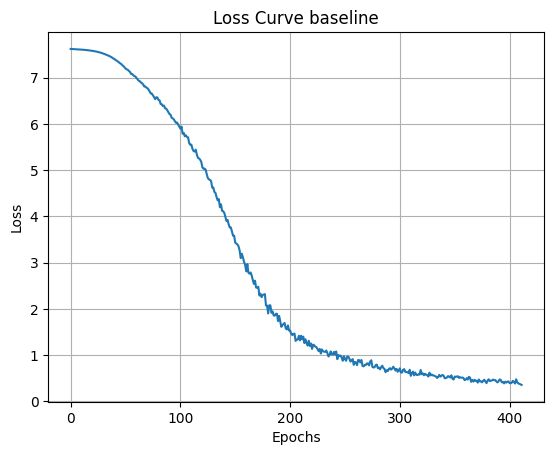

In [70]:
plt.plot(loss_baseline)
plt.title("Loss Curve baseline")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [71]:
class TrainingDataConvex(Dataset):
    def __init__(self, params):
        self.n = params.d_vocab

    def __getitem__(self, idx):

        return idx, idx, idx

    def __len__(self):
        return self.n


# set seed -> random select in gettitem

In [72]:
def train_convex(model, params):

    loss_history = []

    print("Loading data...")
    train_data = TrainingDataConvex(params=params)
    print("Train data defined")
    dataloader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)
    print("Data loaded")

    optimizer = t.optim.AdamW(
        model.parameters(),
        lr=params.lr,
    )

    for epoch in range(412):
        for i, batch in enumerate(dataloader):
            print(i * params.batch_size)
            loss = training_step(
                model=model, optimizer=optimizer, batch=batch, params=params
            )

            loss_history.append(loss.detach().item())

    return loss_history

In [73]:
loss_convex = train_convex(model=model_convex, params=params_compare)

Loading data...
Train data defined
Data loaded
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [74]:
len(loss_convex)

412

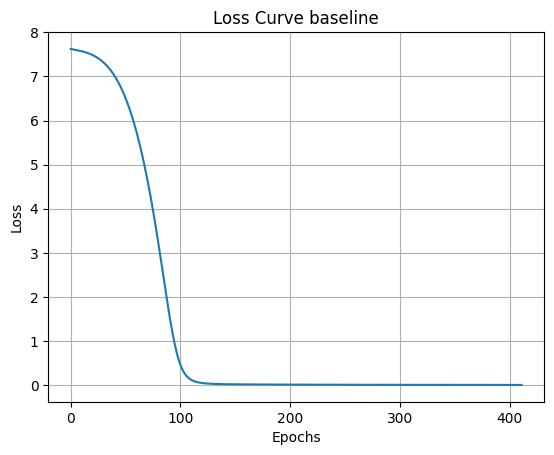

In [75]:
plt.plot(loss_convex)
plt.title("Loss Curve baseline")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [76]:
symmetry_proof_loss(model=model_baseline, params=params)

0.0
0.0004885197850512946
0.0009770395701025891
0.0014655593551538837
0.0019540791402051783
0.002442598925256473
0.0029311187103077674
0.003419638495359062
0.0039081582804103565
0.004396678065461651
0.004885197850512946
0.00537371763556424
0.005862237420615535
0.006350757205666829
0.006839276990718124
0.0073277967757694185
0.007816316560820713
0.008304836345872008
0.008793356130923302
0.009281875915974597
0.009770395701025891
0.010258915486077186
0.01074743527112848
0.011235955056179775
0.01172447484123107
0.012212994626282364
0.012701514411333659
0.013190034196384953
0.013678553981436248
0.014167073766487542
0.014655593551538837
0.015144113336590131
0.015632633121641426
0.01612115290669272
0.016609672691744015
0.01709819247679531
0.017586712261846604
0.0180752320468979
0.018563751831949193
0.019052271617000488
0.019540791402051783
0.020029311187103077
0.02051783097215437
0.021006350757205666
0.02149487054225696
0.021983390327308255
0.02247191011235955
0.022960429897410845
0.0234489496

(tensor(0.3897), 55.609352111816406)

In [78]:
symmetry_proof_loss(model=model_convex, params=params)

0.0
0.0004885197850512946
0.0009770395701025891
0.0014655593551538837
0.0019540791402051783
0.002442598925256473
0.0029311187103077674
0.003419638495359062
0.0039081582804103565
0.004396678065461651
0.004885197850512946
0.00537371763556424
0.005862237420615535
0.006350757205666829
0.006839276990718124
0.0073277967757694185
0.007816316560820713
0.008304836345872008
0.008793356130923302
0.009281875915974597
0.009770395701025891
0.010258915486077186
0.01074743527112848
0.011235955056179775
0.01172447484123107
0.012212994626282364
0.012701514411333659
0.013190034196384953
0.013678553981436248
0.014167073766487542
0.014655593551538837
0.015144113336590131
0.015632633121641426
0.01612115290669272
0.016609672691744015
0.01709819247679531
0.017586712261846604
0.0180752320468979
0.018563751831949193
0.019052271617000488
0.019540791402051783
0.020029311187103077
0.02051783097215437
0.021006350757205666
0.02149487054225696
0.021983390327308255
0.02247191011235955
0.022960429897410845
0.0234489496

(tensor(1.6552), 67.38567185401917)

In [ ]:
symmetry_proof_accuracy(model=model_baseline, params=params_compare)